# Random Forest

### Training model on complete dataset, i.e., without removing collinear features.

In [1]:
#Importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score

In [2]:
#Providing dataset filepath

root='datasets/'

In [3]:
#Reading the final dataset pickle file into a dataframe.

dataframe = pd.read_pickle(root + 'final_feature_data.pkl')
dataframe.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,...,41.0,0.694915,5.9,0.705833,6,6,9,0.666667,1.0,0.666667


In [4]:
# Function to reduce memory of the data frame
def reduce_mem(df):
    
    st_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of the dataframe is :",st_mem_usg,"MB")
    
    for column in df.columns:
        if df[column].dtypes in ["int64", "int32", "int16"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.iinfo(np.int8).min and colMax < np.iinfo(np.int8).max:
                df[column] = df[column].astype(np.int8)
            
            elif colMin > np.iinfo(np.int16).min and colMax < np.iinfo(np.int16).max:
                df[column] = df[column].astype(np.int16)
            
            elif colMin > np.iinfo(np.int32).min and colMax < np.iinfo(np.int32).max:
                df[column] = df[column].astype(np.int32)
        
        if df[column].dtypes in ["float64", "float32"]:
            
            colMin = df[column].min()
            colMax = df[column].max()
            
            if colMin > np.finfo(np.float16).min and colMax < np.finfo(np.float16).max:
                df[column] = df[column].astype(np.float16)
            
            elif colMin > np.finfo(np.float32).min and colMax < np.finfo(np.float32).max:
                df[column] = df[column].astype(np.float32)
    
    print("Memory usage total")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage: ",mem_usg," MB")
    print("Size reduced by ",100*mem_usg/st_mem_usg,"%")
    
    return df

In [5]:
#Reducing dataframe memory consumption for storage management.

dataframe = reduce_mem(dataframe)

Memory usage of properties dataframe is : 4380.480062484741  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1309.2947788238525  MB
This is  29.88929889298893 % of the initial size


In [6]:
dataframe['order_diff'] = dataframe.order_number - dataframe.product_last_bought_order

In [7]:
dataframe.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [8]:
dataframe

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,2.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,...,0.472900,9.921875,0.536621,8,20,9,0.750000,0.700195,0.444336,7.0


In [9]:
#Taking a subset from complete dataset to train the model in stipulated time (complete dataset can be taken if we have more computation power).

dataframe=dataframe.sample(frac=.10)
dataframe

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
3320409,1.0,0.0,0.000000,7.000000,4.000000,16.0,0.0,0.0,0.0,26.0,...,0.410156,7.121094,0.455078,5,12,6,0.199951,0.333252,1.000000,10.0
4159094,1.0,0.0,0.000000,46.000000,21.000000,8.0,0.0,0.0,0.0,10.0,...,0.397705,39.125000,0.462158,55,46,14,0.490967,0.934570,0.856934,2.0
1053816,2.0,1.0,0.500000,9.500000,6.000000,28.0,0.0,0.0,0.0,43.0,...,0.563965,7.808594,0.653320,15,12,10,0.799805,0.916504,0.700195,15.0
5583612,4.0,3.0,0.750000,9.500000,3.250000,5.0,0.0,0.0,0.0,46.0,...,0.660645,17.218750,0.691895,19,10,19,0.947266,0.899902,0.789551,41.0
3902389,1.0,0.0,0.000000,1.000000,6.000000,3.0,0.0,0.0,0.0,4.0,...,0.033325,10.000000,0.030304,12,7,11,0.000000,0.000000,0.090881,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7545171,2.0,1.0,0.500000,11.000000,8.000000,80.0,0.0,0.0,0.0,88.0,...,0.626465,8.859375,0.709961,6,9,9,0.833496,0.777832,0.555664,8.0
8183827,1.0,0.0,0.000000,6.000000,0.000000,1.0,0.0,0.0,0.0,9.0,...,0.224976,10.000000,0.205200,5,15,14,0.199951,0.399902,0.428467,8.0
8304572,3.0,2.0,0.666504,13.335938,5.667969,8.0,1.0,1.0,0.0,9.0,...,0.505371,11.375000,0.432129,11,15,14,0.545410,0.866699,0.714355,1.0
1207742,1.0,0.0,0.000000,17.000000,0.000000,1.0,0.0,0.0,0.0,4.0,...,0.137939,19.328125,0.134033,17,24,17,0.000000,0.166626,0.235352,3.0


In [10]:
label = 'reordered'
x_cols = dataframe.columns.drop('reordered')

In [11]:
X = dataframe[x_cols]
y = dataframe[label]

In [12]:
#Splitting the dataset into training and testing data.
#Stratify parameter is used to make a split so that ratio of values in the sample produced will be same/
#as the ratio of values given to it.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(635599, 67) (635599,)
(211867, 67) (211867,)


In [13]:
y_train.value_counts()

0.0    573324
1.0     62275
Name: reordered, dtype: int64

In [14]:
#Determining parameter grid for estimator.

params={
    'max_depth': [3,4,5,10,15],
    'min_samples_split': [2,3,4,5],
    'class_weight': [{0:1, 1:10}]
}

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf= RandomForestClassifier()

In [17]:
#Using RandomizedSearchCV to cross-validate and perform hyper-parameter tuning.

from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV (estimator= rf, param_distributions = params, cv = 3, random_state=100, n_jobs = -1)

In [18]:
#Training the model.

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 10}],
                                        'max_depth': [3, 4, 5, 10, 15],
                                        'min_samples_split': [2, 3, 4, 5]},
                   random_state=35)

In [19]:
y_pred_rf=rf_random.predict(X_test)

In [20]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions_rf = [1 if i > 0.5 else 0 for i in y_pred_rf]

In [21]:
rf_random.best_params_

{'min_samples_split': 2, 'max_depth': 15, 'class_weight': {0: 1, 1: 10}}


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.90    191109
         1.0       0.31      0.63      0.41     20758

    accuracy                           0.82    211867
   macro avg       0.63      0.74      0.65    211867
weighted avg       0.89      0.82      0.85    211867

Accuracy   Score :  0.823134324835864
F1 Score:  0.4115762695895229


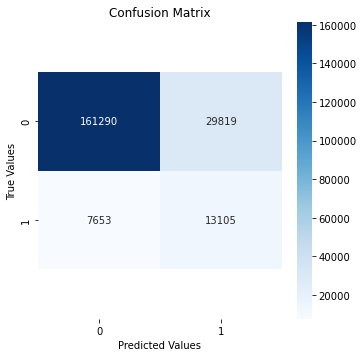

In [22]:
print ("\n Classification report : \n",classification_report (y_test, predictions_rf))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions_rf))

#Generate confusion-matrix as below
conf_matrix_rf= confusion_matrix (y_test,predictions_rf)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_rf, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.xlabel ('Predicted Values')
plt.title ('Confusion Matrix')
plt.ylabel ('True Values')

#Generate F1-score as below
f1_rf = f1_score(y_test, predictions_rf)
print("F1 Score: ", f1_rf)

### Training model on updated dataset, i.e., by removing collinear features.

In [23]:
#Reading the updated dataset pickle file with collinear features removed, into a dataframe.

df_non_collinear = pd.read_pickle(root + 'corr_removed_feature_data.pkl')
df_non_collinear.head()

,user_id,product_id,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,...,std_since_order,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,0.900000,1.400000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
1,1,10258,9.0,0.888889,3.333333,19.562500,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
2,1,10326,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
3,1,12427,10.0,0.900000,3.300000,17.593750,10.0,1.0,1.0,1.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667
4,1,13032,3.0,0.666667,6.333333,21.671875,10.0,1.0,0.0,0.0,...,10.559065,59,0.694915,5.9,6,6,9,0.666667,1.0,0.666667


In [24]:
#Reducing dataframe memory consumption for storage management.

df_non_collinear = reduce_mem(df_non_collinear)

Memory usage of properties dataframe is : 3281.319013595581  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  913.2735185623169  MB
This is  27.832512315270936 % of the initial size


In [25]:
df_non_collinear['order_diff'] = df_non_collinear.order_number - df_non_collinear.product_last_bought_order

In [26]:
df_non_collinear.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [27]:
df_non_collinear

,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,...,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
1,9.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
2,1.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,6.0
3,10.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
4,3.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,4.0,...,59,0.694824,5.898438,6,6,9,0.666504,1.000000,0.666504,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,0.666504,8.000000,23.328125,12.0,1.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,2.0
8474657,1.0,0.000000,8.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0
8474658,1.0,0.000000,8.000000,30.000000,11.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,3.0
8474659,1.0,0.000000,6.000000,9.000000,7.0,0.0,0.0,0.0,14.0,6.0,...,129,0.472900,9.921875,8,20,9,0.750000,0.700195,0.444336,7.0


In [28]:
#Taking a subset from complete dataset to train the model in stipulated time (complete dataset can be taken if we have more computation power).

df_non_collinear=df_non_collinear.sample(frac=.10)
df_non_collinear

,total_product_orders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,...,total_products_by_user,reorder_propotion_by_user,average_order_size,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
6151452,1.0,0.000000,8.0,3.000000,10.0,0.0,0.0,0.0,28.0,1.0,...,235,0.497803,8.703125,6,1,9,1.000000,1.000000,1.000000,18.0
6885693,1.0,0.000000,1.0,1.000000,23.0,0.0,0.0,0.0,67.0,0.0,...,757,0.679199,11.468750,19,18,6,0.684082,0.888672,1.000000,44.0
520704,5.0,0.799805,19.0,8.203125,9.0,0.0,0.0,0.0,35.0,6.0,...,654,0.758301,19.234375,24,21,28,0.875000,0.952148,0.928711,26.0
4060813,2.0,0.500000,12.5,16.000000,7.0,1.0,0.0,0.0,8.0,3.0,...,204,0.524414,29.140625,19,19,46,0.473633,1.000000,0.673828,1.0
8408011,1.0,0.000000,3.0,17.000000,2.0,0.0,0.0,0.0,4.0,6.0,...,12,0.166626,4.000000,2,3,7,0.000000,0.000000,0.285645,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437988,1.0,0.000000,6.0,6.000000,38.0,0.0,0.0,0.0,63.0,5.0,...,781,0.652832,12.593750,13,12,23,0.922852,0.833496,0.782715,25.0
1814981,1.0,0.000000,13.0,15.000000,16.0,0.0,0.0,0.0,22.0,4.0,...,177,0.564941,8.429688,1,3,5,1.000000,0.000000,0.600098,6.0
3802832,1.0,0.000000,4.0,3.000000,3.0,0.0,0.0,0.0,19.0,0.0,...,195,0.620605,10.835938,8,10,9,0.875000,0.700195,0.666504,16.0
6653216,1.0,0.000000,26.0,13.000000,2.0,0.0,0.0,0.0,8.0,1.0,...,101,0.217773,14.429688,18,6,5,0.277832,0.333252,0.799805,6.0


In [29]:
label_non_collinear = 'reordered'
x_cols_non_collinear = df_non_collinear.columns.drop('reordered')

In [30]:
X = df_non_collinear[x_cols_non_collinear]
y = df_non_collinear[label_non_collinear]

In [31]:
#Splitting the dataset into training and testing data.

X_train, X_test, y_train, y_test = train_test_split (X, y, stratify = y, test_size = 0.25)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(635599, 50) (635599,)
(211867, 50) (211867,)


In [32]:
#Using RandomizedSearchCV to cross-validate and perform hyper-parameter tuning.

rf_random_non_collinear = RandomizedSearchCV(estimator = rf, param_distributions = params, cv = 3, random_state=100, n_jobs = -1)

In [33]:
#Training the model.

rf_random_non_collinear.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': [{0: 1, 1: 10}],
                                        'max_depth': [3, 4, 5, 10, 15],
                                        'min_samples_split': [2, 3, 4, 5]},
                   random_state=35)

In [34]:
y_pred_rf=rf_random_non_collinear.predict(X_test)

In [35]:
#Classifying output variable as 0 and 1 as per threshold value of 0.5

predictions_rf = [1 if i > 0.5 else 0 for i in y_pred_rf]


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89    191214
         1.0       0.30      0.63      0.41     20653

    accuracy                           0.82    211867
   macro avg       0.63      0.74      0.65    211867
weighted avg       0.89      0.82      0.85    211867

Accuracy   Score :  0.8205949959172499
F1 Score:  0.40755634527260826


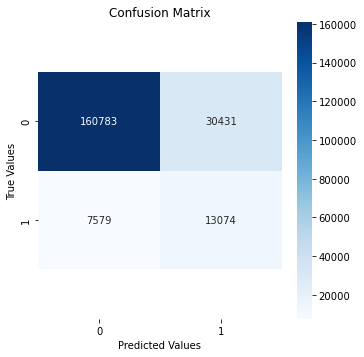

In [36]:
print ("\n Classification report : \n",classification_report (y_test, predictions_rf))
print ("Accuracy   Score : ",accuracy_score (y_test, predictions_rf))

#Generate confusion-matrix as below
conf_matrix_rf= confusion_matrix (y_test,predictions_rf)
plt.figure (figsize=(12,12))
plt.subplot (221)
sns.heatmap (conf_matrix_rf, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.xlabel ('Predicted Values')
plt.title ('Confusion Matrix')
plt.ylabel ('True Values')

#Generate F1-score as below
f1_rf = f1_score (y_test, predictions_rf)
print ("F1 Score: ", f1_rf)